# Net heat flux

This notebook contains the code used to plot the mean net heat flux over each one of the regions described in the notebook [Regions](./Distribution-regions.ipynb). The dataset used here corresponds to the ERA5 monthly averaged data on single levels from 2005 to 2018. The variables downloaded are Surface latent heat flux, Surface net solar radiation, Surface net thermal radiation and Surface sensible heat flux, in $J m^{-2}$. 

For brevity, the notebook only considers one example for one of the subregions. This notebook has the following structure:

   [1. Imported modules](#1.-Imported-modules)
   
   [2. Dictionaries used](#2.-Dictionaries-used)
   
   [3. Functions](#3.-Functions)
   
   [4. Example plot](#4.-Example-plot)
    
Figures of this kind can be found in the written report [MLD project](https://www.overleaf.com/read/rmjfbdbbrsbf
), in the General presentation of the regions. In Section (3.1), (4.1), (5.1) and Chapter 6.

## 1. Imported modules

In [1]:
import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.path as mpath


import warnings; warnings.simplefilter('ignore')

# 2. Dictionaries used

In [2]:
"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


# 3. Functions

In [3]:
## Function to crop the dataset

## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)



def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)



def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines. In Cartopy 
        0.16.0 it is not possible to use xticks and yticks for non-rectangular
        projections, this function is available for Cartopy 0.18.0

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    #ax.set_xticks(xtick, crs=ccrs.PlateCarree())  
    #ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')

    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)   

# 4. Example plot

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_1 = '/home/lgarcia/Documents/Other_datasets/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'Heat-Monthly.nc'
fl_n15 = 'ARMOR_*.nc'


c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)
c_armor15 = Masking(c_armor15, c_armor15.to[0,18])
c_armor15 = Crops('noa', c_armor15, reg_ext)

heat = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
heat = heat.reindex(latitude=heat.latitude[::-1])
heat = Crops('noa', heat, reg_ext)

In [5]:
## Conversion factor from Jm-2 to Wm-2

fact = 86400.

In [6]:
## Re-indexing heat dataset. 

heat = heat.reindex(latitude=c_armor15.latitude, longitude=c_armor15.longitude, method='nearest')

In [7]:
## net heat flux = addition of all components

net = (heat.slhf + heat.ssr + heat.str + heat.sshf)

In [8]:
## Using the coords of ARMOR3D dataset

heat.coords['longitude'] = (('longitude'), c_armor15.longitude.values)
heat.coords['latitude'] = (('latitude'), c_armor15.latitude.values)

In [9]:
## computing the mean

net_mean = net.mean(dim='time')/86400.

### 4.1 Nordic Seas

In [10]:
reg = 'nor'
nor = Crops(reg, net_mean, reg_ext)

## max and min for the heatmap limits

hn_min_nr = nor.min(skipna=True).values
hn_max_nr = nor.max(skipna=True).values

print(hn_min_nr, hn_max_nr)

-170.04909 14.866986


In [11]:
## Information of the plot::
## Title for the figure
## label, colormap and number of intervals of the color bar

fig_title = 'Net surface heat flux [W m$^{-2}$] \nNordic Sea' 
cb_label = 'net heat flux [W m$^{-2}$]'    # Label for colorbar
cmap = 'bwr'
levels = np.linspace(-170., 170., 25)

## Variable to plot
mapping_var = nor.where(c_armor15.mask==1)   

In [12]:
## Information about the region and projection.

## Boundary latitudes and longitudes
lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
region = [lon1, lon2, lat1, lat2]

## Number of ticks in x&y axis.
## In this Cartopy version is not useful.
## Anyway I computed them, because I use them in a function below.
xtick = np.linspace(lon1, lon2, num=5)
ytick = np.linspace(lat1, lat2, num=4)

## Type of projection
projection = projection = ccrs.AlbersEqualArea(central_longitude=-2.5,
                            central_latitude=75,
                            standard_parallels=(lat1, lat2))
data_crs = ccrs.PlateCarree()

## x&y mesh to plot
x_n, y_n = Grid(nor)

<IPython.core.display.Javascript object>


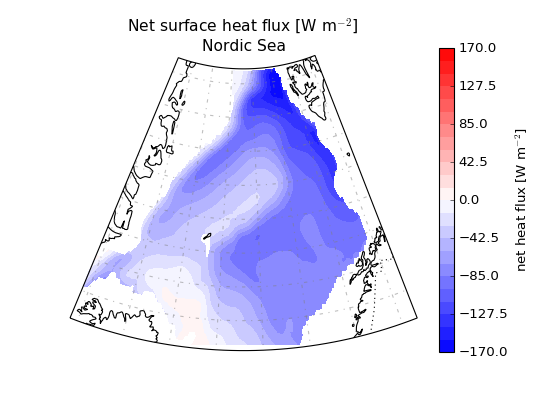

In [13]:
%matplotlib notebook

plt.close()


fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                        figsize=(7,5)) 
contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='neither',
                    transform=data_crs)

cbar = fig.colorbar(contr1, ax=ax, shrink=0.95, orientation='vertical',
                    label=cb_label)



## Ploting the map
Map(ax, region, xtick, ytick)
## Boundary of the map
vertices = [(lon, lat1) for lon in range(int(lon1), int(lon2+1), 1)]+ \
           [(lon, lat2) for lon in range(int(lon2), int(lon1+1), -1)]

boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=data_crs)


## Title of the plot, saving name
ax.set_title(fig_title, fontsize=14)
#plt.savefig(dir_o + 'Nor-heat.png', bbox_inches='tight')
plt.show()